In [1]:
!pip install --upgrade tables
!pip install eli5

     |████████████████████████████████| 4.3MB 3.4MB/s 
  Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4
     |████████████████████████████████| 112kB 3.4MB/s 


In [0]:
import pandas as pd
import numpy as np

from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import cross_val_score

import eli5
from eli5.sklearn import PermutationImportance

## Loading data


In [14]:
cd "/content/drive/My Drive/Colab Notebooks/matrix/matrix_two/ml_car_prices"

/content/drive/My Drive/Colab Notebooks/matrix/matrix_two/ml_car_prices


In [15]:
df = pd.read_hdf('data/car.h5')
df.shape

(106494, 155)

In [18]:
df.columns.values

array(['breadcrumb', 'created_at', 'price_currency', 'price_details',
       'price_value', 'seller_address', 'seller_name', 'seller_type',
       'feature_czujniki-parkowania-przednie',
       'feature_poduszka-powietrzna-chroniąca-kolana',
       'feature_kurtyny-powietrzne', 'feature_klimatyzacja-dwustrefowa',
       'feature_światła-led', 'feature_czujnik-zmierzchu',
       'feature_elektrycznie-ustawiane-lusterka',
       'feature_asr-(kontrola-trakcji)',
       'feature_poduszka-powietrzna-kierowcy', 'feature_cd',
       'feature_elektryczne-szyby-przednie',
       'feature_poduszka-powietrzna-pasażera',
       'feature_system-start-stop', 'feature_światła-do-jazdy-dziennej',
       'feature_komputer-pokładowy', 'feature_elektryczne-szyby-tylne',
       'feature_klimatyzacja-manualna', 'feature_tapicerka-welurowa',
       'feature_czujnik-deszczu', 'feature_światła-przeciwmgielne',
       'feature_ogrzewanie-postojowe', 'feature_radio-niefabryczne',
       'feature_regulowane-zaw

## Dummy model

In [20]:
df.select_dtypes(np.number).columns

Index(['price_value', 'car_id'], dtype='object')

In [27]:
X = df[ ['car_id'] ].values
y = df['price_value']

model = DummyRegressor()
model.fit(X, y)
y_pred = model.predict(X)

mae(y, y_pred)

39465.934630440985

In [31]:
[x for x in df.columns if 'price' in x]
df['price_currency'].value_counts()

PLN    106290
EUR       204
Name: price_currency, dtype: int64

In [32]:
dfn = df[df['price_currency'] != 'EUR']
dfn.shape

(106290, 155)

## Features

In [33]:
dfn.head()

,breadcrumb,created_at,price_currency,price_details,price_value,seller_address,seller_name,seller_type,feature_czujniki-parkowania-przednie,feature_poduszka-powietrzna-chroniąca-kolana,feature_kurtyny-powietrzne,feature_klimatyzacja-dwustrefowa,feature_światła-led,feature_czujnik-zmierzchu,feature_elektrycznie-ustawiane-lusterka,feature_asr-(kontrola-trakcji),feature_poduszka-powietrzna-kierowcy,feature_cd,feature_elektryczne-szyby-przednie,feature_poduszka-powietrzna-pasażera,feature_system-start-stop,feature_światła-do-jazdy-dziennej,feature_komputer-pokładowy,feature_elektryczne-szyby-tylne,feature_klimatyzacja-manualna,feature_tapicerka-welurowa,feature_czujnik-deszczu,feature_światła-przeciwmgielne,feature_ogrzewanie-postojowe,feature_radio-niefabryczne,feature_regulowane-zawieszenie,feature_ogranicznik-prędkości,feature_zmieniarka-cd,feature_szyberdach,feature_isofix,feature_asystent-pasa-ruchu,feature_alufelgi,feature_bluetooth,feature_nawigacja-gps,feature_asystent-parkowania,...,param_particle-filter,param_zarejestrowany-w-polsce,param_oferta-od,param_moc,param_make,param_kraj-pochodzenia,param_engine-power,param_year,param_serwisowany-w-aso,param_rodzaj-paliwa,param_możliwość-finansowania,param_registered-in-poland,param_transmission,param_miesięczna-rata,param_kod-silnika,param_version,param_opłata-początkowa,param_model-pojazdu,param_pojemność-skokowa,param_kierownica-po-prawej-(anglik),param_fuel-type,param_vat-free,param_acrylic,param_damaged,param_door-count,param_tuning,param_filtr-cząstek-stałych,param_nr-of-seats,param_kolor,param_engine-capacity,param_pearl,param_stan,param_wersja,param_emisja-co2,param_body-type,param_matowy,param_bezwypadkowy,param_akryl-(niemetalizowany),param_monthly-payment-value,car_id
0,"[Osobowe, Dacia, Logan, Dacia Logan II (2012-)]","13:23, 5 marca 2018",PLN,Cena Brutto,45100.0,"Krasne 7A - 36-007 Krasne, rzeszowski, Podkarp...",AUTO SPEKTRUM,Dealer,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,...,None,None,Firmy,90 KM,None,None,None,None,None,Benzyna+LPG,None,None,None,None,None,None,None,Logan,898 cm3,None,None,None,None,None,None,None,None,None,Inny kolor,None,None,Nowe,II (2012-),None,None,None,Tak,None,None,0
2,"[Osobowe, Peugeot, 3008, Peugeot 3008 I (2009-...","15:48, 5 marca 2018",PLN,"Cena Brutto, Do negocjacji, Faktura VAT",28000.0,"Tomaszów Mazowiecki, tomaszowski, Łódzkie",None,Osoba prywatna,False,False,False,True,False,False,True,True,True,True,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,...,None,Tak,Osoby prywatnej,115 KM,None,Polska,None,None,None,Diesel,None,None,None,None,None,None,None,3008,1 560 cm3,None,None,None,None,None,None,None,None,None,Czarny,None,None,Używane,I (2009-2016),None,None,None,Tak,None,None,2
3,"[Osobowe, Porsche, Cayenne, Porsche Cayenne II...","06:30, 4 marca 2018",PLN,"Cena Netto, Do negocjacji, Faktura VAT",229500.0,"Kępińska 24a - 63-640 Bralin, kępiński, Wielko...",P.W. GRIB,Dealer,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,True,True,True,False,True,True,True,True,True,False,True,True,True,True,...,None,None,Firmy,262 KM,None,Niemcy,None,None,Tak,Diesel,Tak,None,None,None,None,None,None,Cayenne,3 000 cm3,None,None,None,None,None,None,None,None,None,Czarny,None,None,Używane,II (2010-),None,None,None,None,None,None,3
4,"[Osobowe, Peugeot, 308, Peugeot 308 T7 (2008-2...","08:46, 3 marca 2018",PLN,"Cena Brutto, Do negocjacji",19500.0,"Limanowa, limanowski, Małopolskie",None,Osoba prywatna,False,False,False,False,False,True,True,True,True,True,True,True,False,False,True,True,False,False,True,True,False,False,False,False,False,False,True,False,True,False,False,False,...,None,Tak,Osoby prywatnej,110 KM,None,Polska,None,None,Tak,Diesel,None,None,None,None,None,None,None,308,1

In [36]:
SUFFIX_CAT = '__cat'

for feat in dfn.columns:
  if isinstance(dfn[feat][0], list): continue

  factorized = dfn[feat].factorize()[0]
  if SUFFIX_CAT in feat:
    dfn[feat] = factorized
    continue

  dfn[feat + SUFFIX_CAT] = factorized

dfn.columns.values

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


array(['breadcrumb', 'created_at', 'price_currency', 'price_details',
       'price_value', 'seller_address', 'seller_name', 'seller_type',
       'feature_czujniki-parkowania-przednie',
       'feature_poduszka-powietrzna-chroniąca-kolana',
       'feature_kurtyny-powietrzne', 'feature_klimatyzacja-dwustrefowa',
       'feature_światła-led', 'feature_czujnik-zmierzchu',
       'feature_elektrycznie-ustawiane-lusterka',
       'feature_asr-(kontrola-trakcji)',
       'feature_poduszka-powietrzna-kierowcy', 'feature_cd',
       'feature_elektryczne-szyby-przednie',
       'feature_poduszka-powietrzna-pasażera',
       'feature_system-start-stop', 'feature_światła-do-jazdy-dziennej',
       'feature_komputer-pokładowy', 'feature_elektryczne-szyby-tylne',
       'feature_klimatyzacja-manualna', 'feature_tapicerka-welurowa',
       'feature_czujnik-deszczu', 'feature_światła-przeciwmgielne',
       'feature_ogrzewanie-postojowe', 'feature_radio-niefabryczne',
       'feature_regulowane-zaw

In [0]:
cat_feats = [x for x in dfn.columns if SUFFIX_CAT in x ]
cat_feats = [x for x in cat_feats if 'price' not in x]

In [40]:
len(cat_feats)

151

In [44]:
X = dfn[cat_feats].values
y = dfn['price_value']

model = DecisionTreeRegressor(max_depth=5)
# model.fit(X, y)
# y_pred = model.predict(X)

# mae(y, y_pred)

scores = cross_val_score(model, X, y, cv=3, scoring='neg_mean_absolute_error')

np.mean(scores)

-19650.45289201444

In [49]:
m = DecisionTreeRegressor(max_depth=5)
m.fit(X, y)

imp = PermutationImportance(m, random_state=0).fit(X, y)
eli5.show_weights(imp, feature_names=cat_feats)

Weight,Feature
0.1956 ± 0.0054,param_faktura-vat__cat
0.1903 ± 0.0027,param_napęd__cat
0.1815 ± 0.0087,param_stan__cat
0.1512 ± 0.0078,param_rok-produkcji__cat
0.0928 ± 0.0019,param_skrzynia-biegów__cat
0.0607 ± 0.0051,param_moc__cat
0.0436 ± 0.0015,feature_kamera-cofania__cat
0.0191 ± 0.0022,param_pojemność-skokowa__cat
0.0162 ± 0.0004,feature_bluetooth__cat
0.0110 ± 0.0007,feature_łopatki-zmiany-biegów__cat


In [0]:
def group_and_barplot(feat_groupby, feat_agg='price_value', agg_funcs=[np.mean, np.median, np.size], feat_sort='mean', top=50, subplots=True):
  return(
    dfn
    .groupby(feat_groupby)[feat_agg]
    .agg(agg_funcs)
    .sort_values(by=feat_sort, ascending=False)
    .head(top)
  ).plot(kind='bar', figsize=(18,5), subplots=subplots)

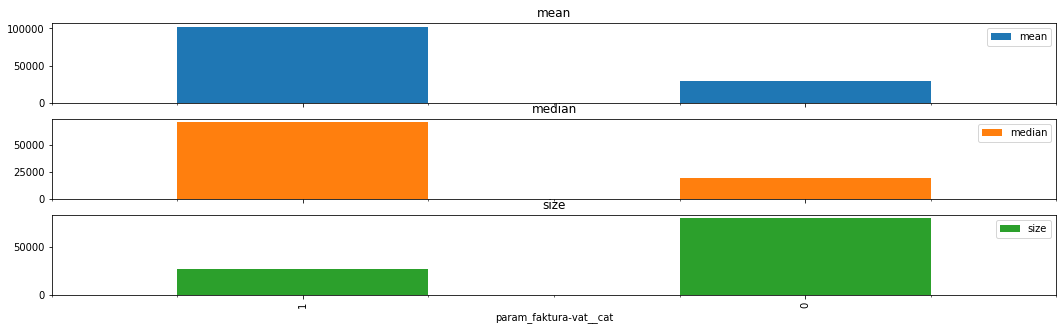

In [57]:
group_and_barplot('param_faktura-vat__cat');